In [1]:
import sys
sys.path.insert(0, '../../')

import graph
import importlib
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import schedule as sch
import topo
import typing
import utils
import yaml
from scripts.cut_exp import *
from tqdm.notebook import tqdm

matplotlib.rc('font', family='Times New Roman', size=16)

In [2]:
def unit_size_cb(r: int):
    return 10000 * math.pow(10, random.randint(0, 1))

def gen_graphs(graph_count, source_selector_dict, max_source_num):
    source_selector = graph.MultiDomainSourceSelector(source_selector_dict)
    global source_quota
    source_quota = max_source_num
    def source_num(i):
        global source_quota
        assert graph_count - i <= source_quota
        delta = source_quota - (graph_count - i)
        ret = 1 + random.randint(0, min(delta, 2))
        source_quota -= ret
        return ret
    gen_args_list = [
            {
            "total_rank": random.randint(3, 7),
            "max_node_per_rank": random.randint(1, 3),
            "max_predecessors": random.randint(1, 2),
            "mi_cb": lambda: 1,
            "memory_cb": lambda: int(2e8),
            "unit_size_cb": unit_size_cb,
            "unit_rate_cb": lambda: random.randint(10, 20),
            "source_hosts": source_selector,
            "sink_hosts": ["cloud1"],
            "sources_num": source_num(i),
        }
        for i in range(graph_count)
    ]
    return [
        graph.MultiSourceGraphGenerator("g" + str(idx), **gen_args).gen_dag_graph()
        for idx, gen_args in enumerate(gen_args_list)
    ]

def big_avg(array):
    return sum(array) / len(array)

In [3]:
from tqdm.notebook import trange

def run(sc, labels, source_selector_dict, max_source_num,
        run_best: bool = True):
    # base_data = [[] for _ in labels]
    # best_data = [[] for _ in labels]
    # flow_data = [[] for _ in labels]
    # greedy_data = [[] for _ in labels]
    # greedy2_data = [[] for _ in labels]

    test_round = 100
    best_box_data = np.zeros((len(labels), test_round))
    flow_box_data = np.zeros((len(labels), test_round))
    greedy_box_data = np.zeros((len(labels), test_round))
    greedy2_box_data = np.zeros((len(labels), test_round))
    for idx, graph_count in enumerate(labels):
        print(graph_count)
        for r in trange(test_round, desc="running with {} graphs".format(graph_count)):
            graph_list = gen_graphs(graph_count, source_selector_dict, max_source_num)
            base = sum(bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, all_cloud_cut(sc, graph_list)))
            flow = sum(bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, multiedge_flow_cut(sc, graph_list)))
            greedy = sum(bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, multiedge_greedy_cut(sc, graph_list)))
            greedy2 = sum(bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, multiedge_greedy_cut2(sc, graph_list)))
            if flow > base:
                print('flow {}, base {}'.format(flow, base))
            # base_data[idx].append(base)
            # flow_data[idx].append(flow)
            # greedy_data[idx].append(greedy)
            # greedy2_data[idx].append(greedy2)
            flow_box_data[idx][r] = flow / base
            greedy_box_data[idx][r] = greedy / base
            greedy2_box_data[idx][r] = greedy2 / base
            if run_best:
                best = sum(bd_calc(g, gc[0], gc[1]) for g, gc in zip(graph_list, multiedge_best_cut(sc, graph_list)))
                if flow < best:
                    print('flow {}, best {}'.format(flow, best))
                # best_data[idx].append(best)
                best_box_data[idx][r] = best / base
                
    print('flow', flow_box_data.mean(axis=1) / 1e6)
    print('greedy', greedy_box_data.mean(axis=1) / 1e6)
    print('greedy2', greedy2_box_data.mean(axis=1) / 1e6)
    if run_best:
        print('best', best_box_data.mean(axis=1) / 1e6)
    
    return best_box_data, flow_box_data, greedy_box_data, greedy2_box_data

In [4]:
sc = topo.Scenario.from_dict(yaml.load(open("../../samples/1e6h.yaml", "r").read(), Loader=yaml.Loader))
best1, flow1, greedy1, greedy21 = run(sc, [4, 8, 12, 16, 20], 
                    {"edge0": {'e0rasp1': 10, 'e0rasp2': 10, 'e0rasp3': 10},
                    "edge1": {'e1rasp1': 10, 'e1rasp2': 10, 'e1rasp3': 10}}, 45)

4


running with 4 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

8


running with 8 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
sc = topo.Scenario.from_dict(yaml.load(open("../../samples/1e18h.yaml", "r").read(), Loader=yaml.Loader))
edge0 = {"e0rasp"+str(i): 12 for i in range(1, 7)}
edge1 = {"e1rasp"+str(i): 12 for i in range(1, 4)}
edge1.update({"e1vm"+str(i): 24 for i in range(1, 4)})
edge2 = {"e2rasp"+str(i): 12 for i in range(1, 5)}
edge2.update({"e2vm"+str(i): 24 for i in range(1, 3)})
source_dict = {"edge0": edge0, "edge1": edge1, "edge2": edge2}
best2, flow2, greedy2, greedy22 = run(sc, [40, 60, 80, 100, 120], source_dict, 200, False)

40


running with 40 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

60


running with 60 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

80


running with 80 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

100


running with 100 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

120


running with 120 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

[]
[0.7505662660169574, 0.7364017742251427, 0.7404130569723419, 0.7521161584532965, 0.7599672244770993]
[1.1934050549550252, 1.0841156833859587, 0.9042216154475269, 0.8404231398354338, 0.850822890844988]
[0.7841505308483566, 0.7750283223269203, 0.7759541458981027, 0.7769480363653978, 0.778774400085528]


In [7]:
sc = topo.Scenario.from_dict(yaml.load(open("../../samples/1e54h.yaml", "r").read(), Loader=yaml.Loader))
edge0 = {"e0rasp"+str(i): 12 for i in range(1, 9)}
edge0.update({"e0vm"+str(i): 24 for i in range(1, 7)})
edge0.update({"e0desktop"+str(i): 48 for i in range(1, 5)})
edge1 = {"e1rasp"+str(i): 12 for i in range(1, 9)}
edge1.update({"e1vm"+str(i): 24 for i in range(1, 7)})
edge1.update({"e1desktop"+str(i): 48 for i in range(1, 5)})
edge2 = {"e2rasp"+str(i): 12 for i in range(1, 9)}
edge2.update({"e2vm"+str(i): 24 for i in range(1, 7)})
edge2.update({"e2desktop"+str(i): 48 for i in range(1, 5)})
source_dict = {"edge0": edge0, "edge1": edge1, "edge2": edge2}
best3, flow3, greedy3, greedy23 = run(sc, [200, 300, 400, 500, 600], source_dict, 1000, False)

200


running with 200 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

300


running with 300 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

400


running with 400 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

500


running with 500 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

600


running with 600 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

[]
[0.7436033669321874, 0.7411570041756544, 0.7410860520481539, 0.7644935864480356, 0.7747945736038031]
[1.1731130292646974, 1.0620031370461214, 0.8525973741002602, 0.850806179059003, 0.8647012802279979]
[0.7784079434077847, 0.7778096618421961, 0.7766818280498106, 0.7838321267783797, 0.7837491506292709]


AttributeError: 'list' object has no attribute 'mean'

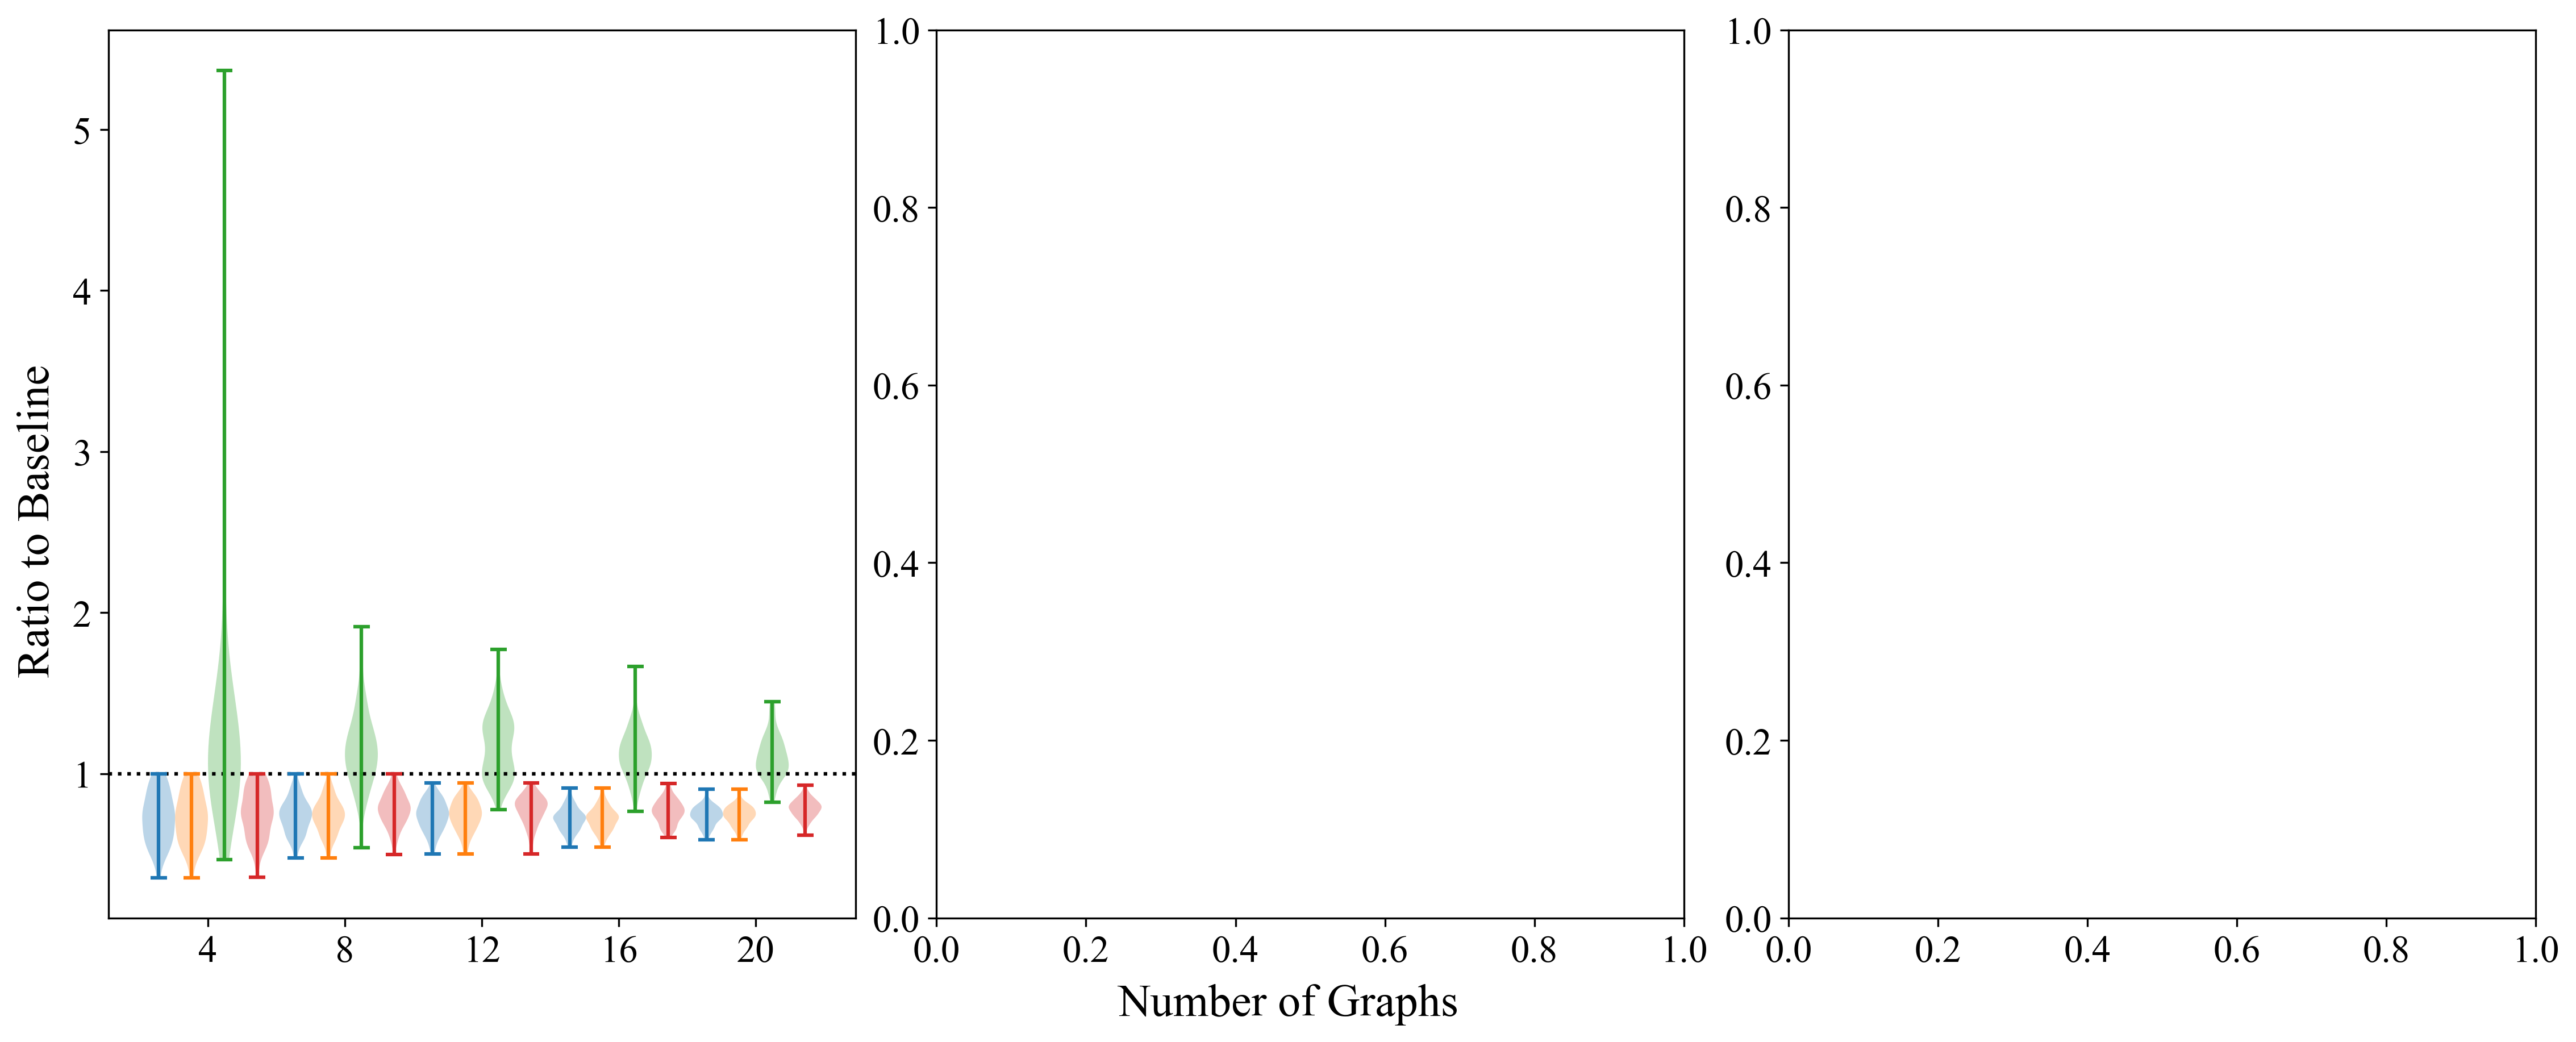

In [15]:
label_count = 5
def postprocess(data):
    return [data[i] for i in range(label_count)]

fig, axes = plt.subplots(1, 3, figsize=(15, 6), dpi=300, constrained_layout=True)
fig.supxlabel('Number of Graphs')
fig.supylabel('Ratio to Baseline')

ax = axes[0]
_ = ax.set_xticks([i+1 for i in range(label_count)])
_ = ax.set_xticklabels([4, 8, 12, 16, 20])
width = 0.24
small_base_plot = ax.axhline(y=1, color='black', linestyle='dotted')
_ = ax.violinplot(postprocess(best1), vert=True, positions=[i-width*3/2 for i in range(1, label_count+1)], widths=width)
_ = ax.violinplot(postprocess(flow1), vert=True, positions=[i-width/2 for i in range(1, label_count+1)], widths=width)
_ = ax.violinplot(postprocess(greedy1), vert=True, positions=[i+width/2 for i in range(1, label_count+1)], widths=width)
_ = ax.violinplot(postprocess(greedy21), vert=True, positions=[i+width*3/2 for i in range(1, label_count+1)], widths=width)
small_best_plot = ax.scatter([i-width*3/2 for i in range(1, label_count+1)], best1.mean(axis=1), marker='o')
small_flow_plot = ax.scatter([i-width/2 for i in range(1, label_count+1)], flow1.mean(axis=1), marker='s')
small_greedy_plot = ax.scatter([i+width/2 for i in range(1, label_count+1)], greedy1.mean(axis=1), marker='D')
small_greedy2_plot = ax.scatter([i+width*3/2 for i in range(1, label_count+1)], greedy21.mean(axis=1), marker='^')
_ = ax.legend([small_base_plot, small_best_plot, small_flow_plot, small_greedy_plot, small_greedy2_plot], ['baseline', 'optimal', 'proposed', 'greedy', 'greedy2'], prop={'size': '16'})

# label_count = 5

# ax = axes[1]
# _ = ax.set_xticks([i+1 for i in range(label_count)])
# _ = ax.set_xticklabels([40, 60, 80, 100, 120])
# width = 0.24
# medium_base_plot = ax.axhline(y=1, color='black', linestyle='dotted')
# _ = ax.violinplot(postprocess(flow2), vert=True, positions=[i-width for i in range(1, label_count+1)], widths=width)
# _ = ax.violinplot(postprocess(greedy2), vert=True, positions=[i for i in range(1, label_count+1)], widths=width)
# _ = ax.violinplot(postprocess(greedy22), vert=True, positions=[i+width for i in range(1, label_count+1)], widths=width)
# medium_flow_plot = ax.scatter([i-width for i in range(1, label_count+1)], flow2.mean(axis=1), marker='o')
# medium_greedy_plot = ax.scatter([i for i in range(1, label_count+1)], greedy2.mean(axis=1), marker='s')
# medium_greedy2_plot = ax.scatter([i+width for i in range(1, label_count+1)], greedy22.mean(axis=1), marker='D')
# _ = ax.legend([medium_base_plot, medium_flow_plot, medium_greedy_plot, medium_greedy2_plot], ['baseline', 'proposed', 'greedy', 'greedy2'], prop={'size': '16'})

# ax = axes[2]
# _ = ax.set_xticks([i+1 for i in range(label_count)])
# _ = ax.set_xticklabels([200, 300, 400, 500, 600])
# width = 0.24
# large_base_plot = ax.axhline(y=1, color='black', linestyle='dotted')
# _ = ax.violinplot(postprocess(flow3), vert=True, positions=[i-width for i in range(1, label_count+1)], widths=width)
# _ = ax.violinplot(postprocess(greedy3), vert=True, positions=[i for i in range(1, label_count+1)], widths=width)
# _ = ax.violinplot(postprocess(greedy23), vert=True, positions=[i+width for i in range(1, label_count+1)], widths=width)
# large_flow_plot = ax.scatter([i-width for i in range(1, label_count+1)], flow3.mean(axis=1), marker='o')
# large_greedy_plot = ax.scatter([i for i in range(1, label_count+1)], greedy3.mean(axis=1), marker='s')
# large_greedy2_plot = ax.scatter([i+width for i in range(1, label_count+1)], greedy23.mean(axis=1), marker='D')
# _ = ax.legend([large_base_plot, large_flow_plot, large_greedy_plot, large_greedy2_plot], ['baseline', 'proposed', 'greedy', 'greedy2'], prop={'size': '16'})

fig.show()